### Problem Statement

I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.

### Dataset

The dataset I chose is the affairs dataset that comes with Statsmodels. It was derived from a survey of women in 1974 by Redbook magazine, in which married women were asked about their participation in extramarital affairs. More information about the study is available in a 1978 paper from the Journal of Political Economy.

### Description of Variables

The dataset contains 6366 observations of 9 variables:
1. rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
2. age: woman's age
3. yrs_married: number of years married
4. children: number of children
5. religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
6. educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
7. occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 =
teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
8. occupation_husb: husband's occupation (same coding as above)
9. affairs: time spent in extra-marital affairs

In [1]:
# necessary imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, roc_auc_score
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Loading our dataset
dta = sm.datasets.fair.load_pandas().data
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666


In [3]:
#add "affair" column: 1 represents having affairs, 0 represents not 
dta['affair'] = (dta.affairs > 0).astype(int)
dta.drop('affairs', axis=1, inplace=True)
dta.head()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,1


In [4]:
dta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6366 entries, 0 to 6365
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rate_marriage    6366 non-null   float64
 1   age              6366 non-null   float64
 2   yrs_married      6366 non-null   float64
 3   children         6366 non-null   float64
 4   religious        6366 non-null   float64
 5   educ             6366 non-null   float64
 6   occupation       6366 non-null   float64
 7   occupation_husb  6366 non-null   float64
 8   affair           6366 non-null   int32  
dtypes: float64(8), int32(1)
memory usage: 422.9 KB


### Exploratory Data Analyis

In [5]:
dta.describe()

,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affair
count,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000,6366.000000
mean,4.109645,29.082862,9.009425,1.396874,2.426170,14.209865,3.424128,3.850141,0.322495
std,0.961430,6.847882,7.280120,1.433471,0.878369,2.178003,0.942399,1.346435,0.467468
min,1.000000,17.500000,0.500000,0.000000,1.000000,9.000000,1.000000,1.000000,0.000000
25%,4.000000,22.000000,2.500000,0.000000,2.000000,12.000000,3.000000,3.000000,0.000000
50%,4.000000,27.000000,6.000000,1.000000,2.000000,14.000000,3.000000,4.000000,0.000000
75%,5.000000,32.000000,16.500000,2.000000,3.000000,16.000000,4.000000,5.000000,1.000000
max,5.000000,42.000000,23.000000,5.500000,4.000000,20.000000,6.000000,6.000000,1.000000


There are no missing values in our data. Our variables here are mainly categorical and discrete vairables. Let's visualize our dataset.

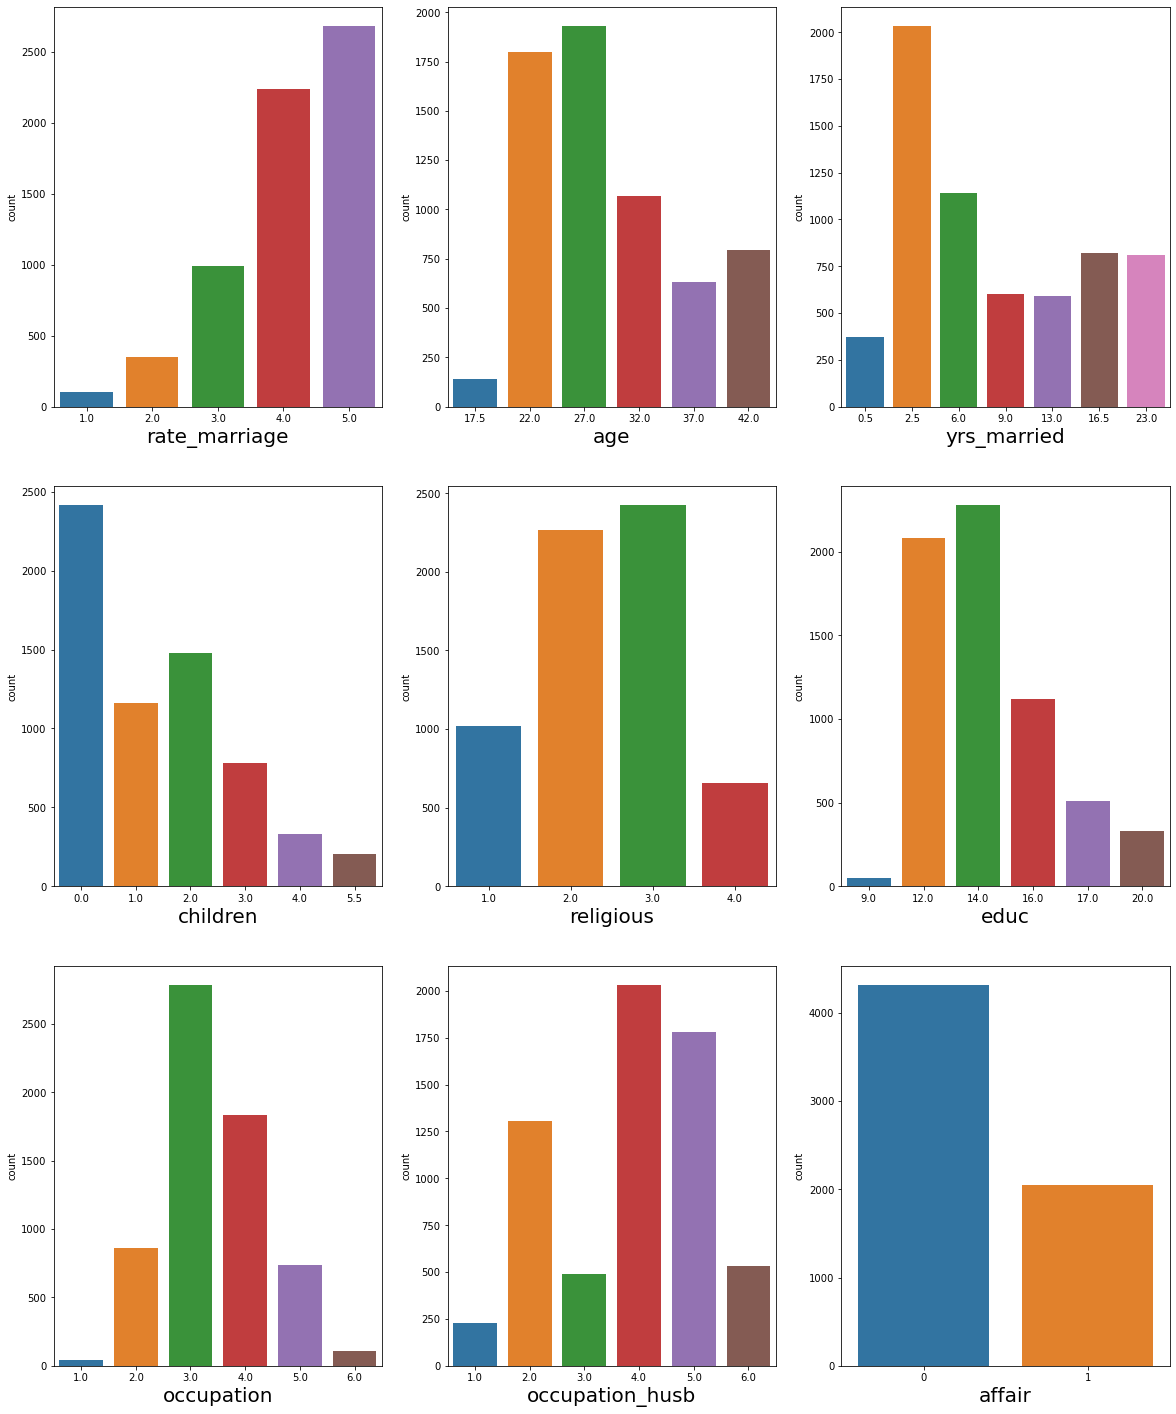

In [6]:
# countplot of all columns
plt.figure(figsize=(20,25), facecolor='white')
plotnumber = 1

for column in dta:
    if plotnumber<=9 :     # as there are 9 columns in the data
        ax = plt.subplot(3,3,plotnumber)
        sns.countplot(dta[column])
        plt.xlabel(column,fontsize=20)
        plotnumber+=1
plt.show()

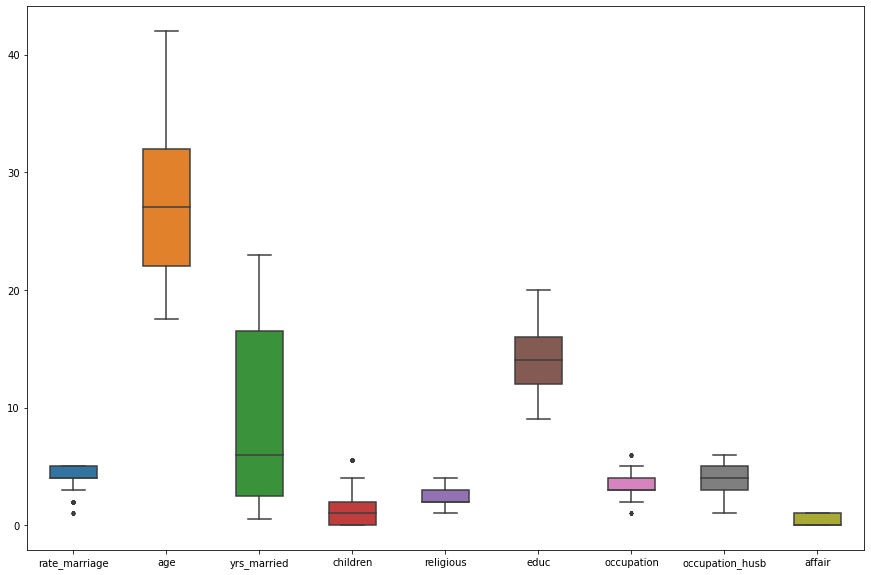

In [7]:
fig, ax = plt.subplots(figsize=(15,10))
sns.boxplot(data=dta, width= 0.5,ax=ax,  fliersize=3)

It was noticed that the children column had values such as 5.5 which is not possible. Let's deal with it.

In [8]:
q = dta['children'].quantile(0.99)
# we are removing the top 1% data from the children column
dta = dta[dta['children']<q]

Let's plot the correlation of the dataset.

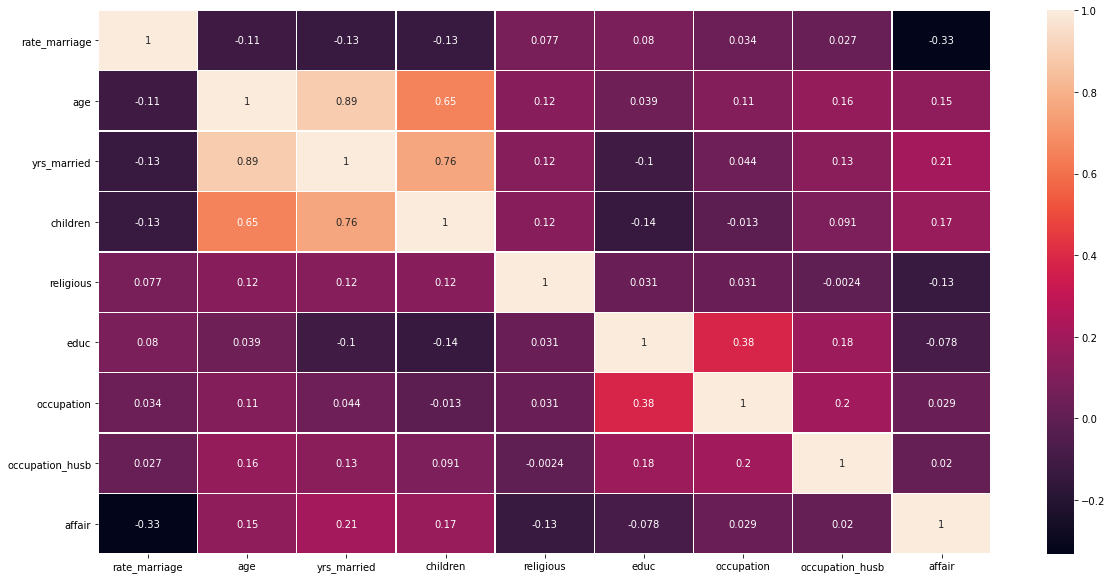

In [9]:
corrMatrix = dta.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(corrMatrix, annot=True,  linewidths=.5, ax=ax)
plt.show()

We can see that age and yrs_married are highly correlated. Let's start preparing our data for model training.

In [10]:
# creation of dummy variables
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', dta, return_type="dataframe")

In [11]:
# renaming of dummy variables
X = X.rename(columns =
{'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})

# creation of an array
y = np.ravel(y)

# removing intercept column
X.drop(["Intercept"], axis = 1, inplace = True)

In [12]:
# creation of train test split
x_train,x_test,y_train,y_test = train_test_split(X,y, test_size= 0.25, random_state = 355)

In [26]:
log_reg = LogisticRegression()

# training our model
log_reg.fit(x_train,y_train)

LogisticRegression()

In [27]:
# testing our model
y_pred = log_reg.predict(x_test)

In [28]:
# model accuracy
accuracy = accuracy_score(y_test,y_pred)
accuracy

0.718364698247891

In [33]:
# cross validation score
cross_val_score(log_reg,X,y)

array([0.70965126, 0.72343877, 0.72506083, 0.71590909, 0.74918831])

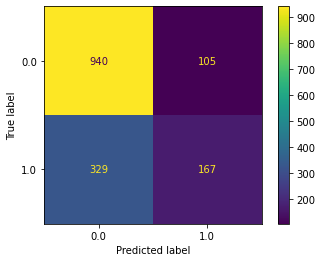

In [31]:
# Confusion Matrix
metrics.plot_confusion_matrix(log_reg, x_test, y_test)

In [22]:
conf_mat = confusion_matrix(y_test,y_pred)
true_positive = conf_mat[0][0]
false_positive = conf_mat[0][1]
false_negative = conf_mat[1][0]
true_negative = conf_mat[1][1]

In [23]:
# Precison
Precision = true_positive/(true_positive+false_positive)
Precision

0.8995215311004785

In [24]:
# Recall
Recall = true_positive/(true_positive+false_negative)
Recall

0.7407407407407407

In [25]:
# F1 Score
F1_Score = 2*(Recall * Precision) / (Recall + Precision)
F1_Score

0.8124459809853067